# Relion comparison

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_mask
from src.projection import project
#from src.interpolate import *

from external.pyem.pyem import star
from external.pyem.pyem.vop import grid_correct
import mrcfile

### The volume

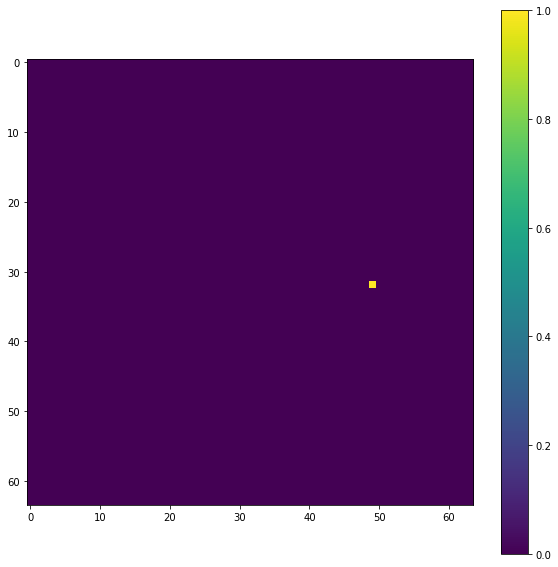

In [3]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1
vol = grid_correct(vol, pfac = 1, order = 1)



vol_relion = np.zeros([nx,nx,nx])
vol_relion[32,32,49] = 1

mip_x(vol_relion); plt.colorbar()


### Relion projection

Write the volume to file so it can be processed by Relion

In [4]:
#with mrcfile.new('../data/pointmass.mrc', overwrite=True) as mrc:
#    mrc.set_data(vol_relion.astype(np.float32))

Then start the Relion Singularity instance on a job on the cluster, go to the data directory and run on of the following:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj.mrc --ctf false```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_rot45tilt_shifts.mrc --pad 1 --angpix 1 --rot 45 --tilt 22.5 --xoff 10 --yoff 55```

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj_star  --ang pyem_onerow.star  --pad 1 --ctf true```




Then load the result:

In [5]:
with mrcfile.open('../data/relion_proj_star.mrcs') as mrc:
    proj_relion = mrc.data

In [6]:
proj_relion

array([[ 5.9780506e-03,  2.2874274e-03,  3.9728772e-04, ...,
        -7.2369576e-03,  1.7026321e-03,  8.6743664e-03],
       [-5.0022174e-03, -4.5050224e-03, -6.1962097e-03, ...,
         2.6422129e-03,  7.3205354e-03, -1.3168351e-03],
       [-4.2104586e-03, -4.5752828e-03, -2.8799505e-03, ...,
         6.9059995e-03, -1.0671464e-03, -4.5341719e-03],
       ...,
       [ 4.6163052e-03,  3.3666040e-03,  2.9199324e-03, ...,
        -4.8251464e-03,  8.4007287e-04,  2.3535478e-03],
       [-5.0072600e-03, -5.9137265e-03, -6.6466215e-03, ...,
         3.2767721e-03,  3.6165665e-03, -2.0162377e-06],
       [ 4.0629038e-04,  5.2608596e-03,  6.3018235e-03, ...,
         2.3748681e-03, -7.4320585e-03, -4.6764873e-03]], dtype=float32)

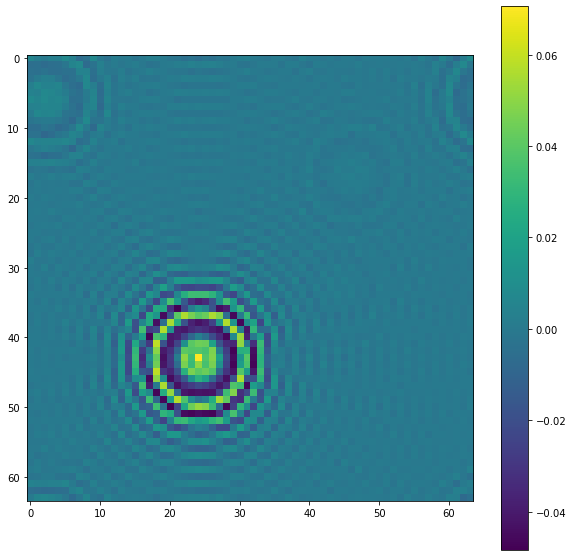

In [7]:
plt.imshow(proj_relion); plt.colorbar()

### My projection

In [8]:
df = star.parse_star("../data/pyem_onerow.star", keep_index = False)
dfiter = df.iterrows()
i, p = next(dfiter)

/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [9]:
pixel_size = star.calculate_apix(p) #* 64.0/66.0

f3d, X, Y, Z = volume_fourier(np.fft.ifftshift(vol), pixel_size)

mymask = create_mask(X,Y,Z, (0,0,0), np.max(X)+X[1,1,0])
f3d = f3d * mymask

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# IMPORTANT: do not make this a Jax array
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])


Parameters from the star file

In [10]:
angles = jnp.array([p[star.Relion.ANGLEPSI],
         p[star.Relion.ANGLETILT],
         p[star.Relion.ANGLEROT]]) / 180* jnp.pi # third angle is rotation around the first z axis

shifts = jnp.array([p[star.Relion.ORIGINX], p[star.Relion.ORIGINY]]) * pixel_size

ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
              'def2'  : p[star.Relion.DEFOCUSV],
              'angast': p[star.Relion.DEFOCUSANGLE], 
              'phase' : p[star.Relion.PHASESHIFT],
              'kv'    : p[star.Relion.VOLTAGE],
              'ac'    : p[star.Relion.AC], 
              'cs'    : p[star.Relion.CS], 
              'bf'    : 0,
              'lp'    : 2 * pixel_size}

In [11]:
f2d, coords_slice = project(f3d, x_grid, y_grid, z_grid, angles, shifts, 'tri', ctf_params)
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
#f2d = np.fft.fftshift(f2d)
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d*mymask[:,:,0])))

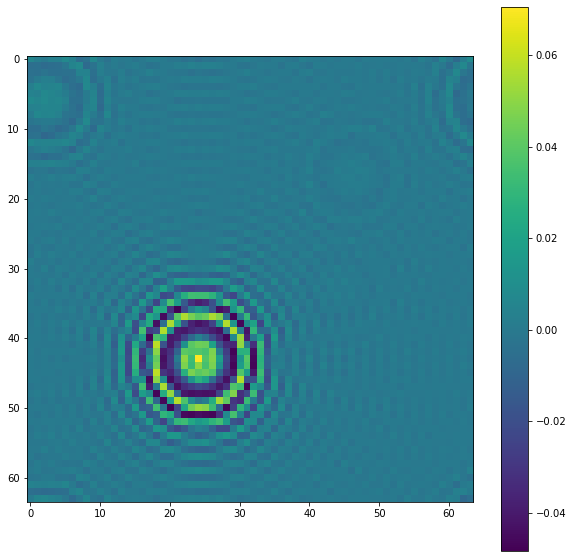

In [12]:
plt.imshow(proj); plt.colorbar()

### Compare

In [13]:
f2d_relion = np.fft.fftshift(np.fft.fftn(proj_relion))
f2d = np.fft.fftshift(np.fft.fftn(proj))

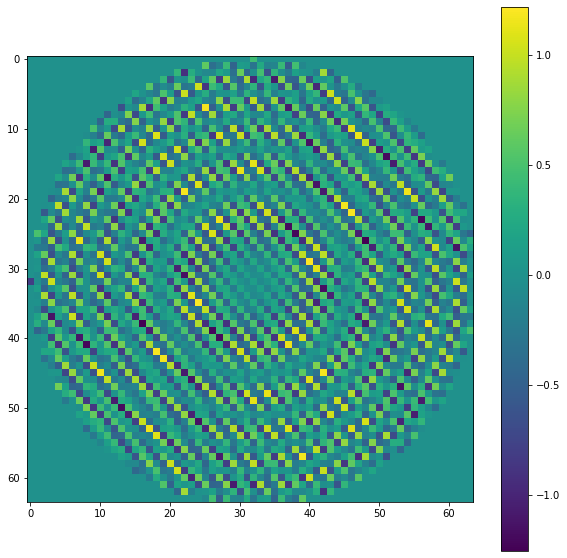

In [14]:
plt.imshow(np.real(f2d)); plt.colorbar()

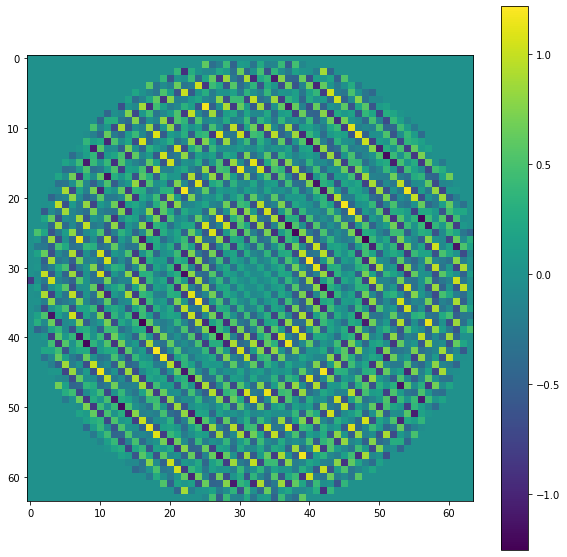

In [15]:
plt.imshow(np.real(f2d_relion)); plt.colorbar()

0.44464428609821444

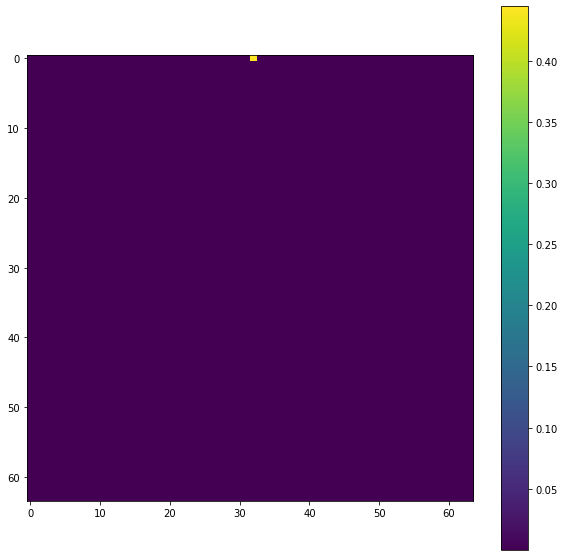

In [16]:
diff = f2d - f2d_relion
plt.imshow(np.abs(diff)); plt.colorbar()
np.max(np.abs(diff))

4.5110590281865573e-08

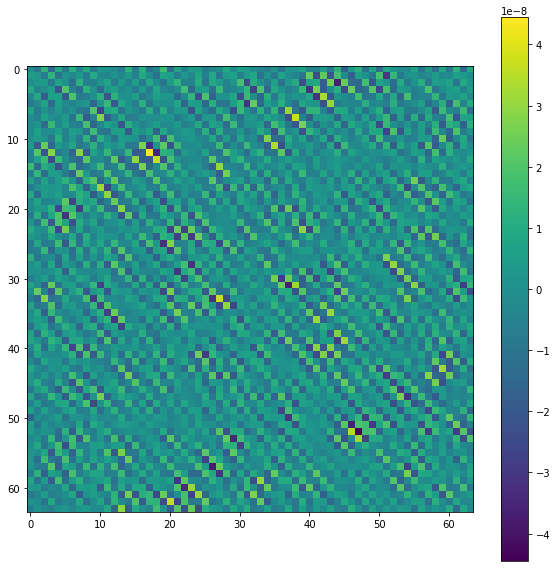

In [17]:
diff[np.abs(diff) > 0.4] = 0
plt.imshow(np.imag(diff)); plt.colorbar()
np.max(np.abs(diff))